In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandasql import sqldf
from sklearn import linear_model
import statsmodels.api as sm
from scipy import stats

In [2]:
CRSP = pd.read_sas('crsp.sas7bdat', encoding='latin-1')
COMP = pd.read_sas('comp.sas7bdat', encoding='latin-1')
FF4 = pd.read_sas('ff4data.sas7bdat', encoding='latin-1')
# COMP_ANNUAL = pd.read_sas('comp_annual.sas7bdat', encoding='latin-1')
# INDUSTRY =  pd.read_csv('industries.csv')

In [3]:
class Factors:
  @staticmethod
  def _create_hedge_portfolio(data: pd.DataFrame, factor_col: str, q=10, direction=1) -> pd.DataFrame:
    """
    Creates a hedge portfolio, using D10 - D1 returns by default.

    Args:
      data (pd.DataFrame): Data, must contain columns ['monthid', 'RET', factor_col]
      factor_col (str): Name of factor column, i.e. ep1
      q (int, optional): Defaults to deciles (10).
      direction (int, optional): Either 1 or -1. If 1, we do High - Low. Otherwise, Low - High.

    Returns: Return of hedge portfolio at each monthid (i.e. the factor)
    """
    factor = []
    index = []  # monthid - 1
    mth_grp = data.groupby('monthid')
    data['rank'] = mth_grp[factor_col].transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False) if not np.isnan(x).all() else x)  # if statement in case all NaN
    for monthid, mdata in mth_grp:
      # TODO: can add value weighting of returns here if anyone needs it
      d1 = mdata[mdata['rank'] == 0]['RET'].mean()
      d10 = mdata[mdata['rank'] == q-1]['RET'].mean()
      factor.append(direction * (d10 - d1))
      index.append(monthid - 1)
    return pd.DataFrame(factor, index=index)

  @staticmethod
  def epq1(data):
    factor = []
    data = data.copy()
    data = data[data['IBQ'] >= 0]
    data['Epq1'] = data['IBQ'] * 1000000 / data['MKTCAP']
    mth_grp = data.groupby('monthid')
    data['rank'] = mth_grp['Epq1'].transform(lambda x: pd.qcut(x, 10, labels=False))
    for _, mdata in mth_grp:
      d1 = mdata[mdata['rank'] == 0]['RET'].mean()
      d10 = mdata[mdata['rank'] == 9]['RET'].mean()
      factor.append(d1 - d10)
    return factor
  
  @staticmethod
  def ioca(data):
    CPI = pd.read_csv('cpi.csv')
    g = .10
    d = .15
    factor = []
    annual_data = sqldf("SELECT a.*, b.* \
                            FROM COMP_ANNUAL as a \
                            INNER JOIN INDUSTRY as b \
                            ON a.SIC >= b.lhs and a.SIC <= b.rhs")
    annual_data['year'] = annual_data['FYEAR'].astype(int)
    annual_data['LPERMNO'] = annual_data['LPERMNO'].astype(int)
    annual_data['XSGA'].fillna(0, inplace=True)
    annual_data = pd.merge(annual_data, CPI, on='year')
    annual_data.sort_values(by=['LPERMNO', 'year', 'XSGA'], inplace=True)
    annual_data.drop_duplicates(subset=['LPERMNO', 'year'], keep='last', inplace=True)
    grouped = annual_data.groupby('LPERMNO')
    oc = []
    for _, grp in grouped:
      prev = None
      for _, row in grp.iterrows():
        if prev == None:
          prev = row['XSGA'] / (g+d)
        else:
          prev = (1 - d) * prev + row['XSGA'] / row['CPI']
        oc.append(prev)
    annual_data['oc'] = oc
    annual_data = annual_data[(annual_data['oc'] > 0) & (annual_data['AT'] > 0)]
    annual_data['oca'] = annual_data['oc'] / annual_data['AT']
    def yearly_winsorize(srs):
      p1, p99 = np.nanpercentile(srs, [1, 99])
      return np.clip(srs, p1, p99)
    annual_data['ioca'] = annual_data.groupby('year')['oca'].transform(yearly_winsorize)
    annual_data['ioca'] = annual_data.groupby('industry')['ioca'].transform(lambda x: (x - x.mean()) / x.std())
    data = sqldf("SELECT a.*, b.ioca \
                  FROM data as a \
                  INNER JOIN annual_data as b \
                  ON a.PERMNO = b.LPERMNO and \
                  ((a.year = b.year and a.month >= 7) or \
                    (a.year = b.year + 1 and a.month <= 6))")
    mth_grp = data.groupby('monthid')
    data['rank'] = mth_grp['ioca'].transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))
    for _, mdata in mth_grp:
      d1 = mdata[mdata['rank'] == 0]['RET'].mean()
      d10 = mdata[mdata['rank'] == 9]['RET'].mean()
      factor.append(d10 - d1)
    return factor

  @staticmethod
  def Abr1(data):
    factor = []
    data = data.copy()

  @staticmethod
  def e11(data):
    """
    Calculate ε11 factor (Residual momentum, prior 11-month returns) with 1 month holding period.
    """
    data = data.copy()
    
    # Get a series of rf indexed by date
    rf = data.set_index("monthid")[["RF"]].reset_index().drop_duplicates(subset="monthid")
    rf = rf.set_index("monthid").sort_index().RF

    # Get xret with each permno in a column
    xret = data.loc[:,~data.columns.duplicated()].pivot_table(index="monthid", columns="PERMNO", values="RET").sort_index()
    xret = xret.sub(rf, axis=0)

    # Get ff data with constant
    ff_3 = data[["monthid", "SMB", "HML", "MKTRF"]].drop_duplicates(subset="monthid").set_index("monthid").sort_index()
    ff_3 = sm.add_constant(ff_3)

    from numpy.linalg import pinv

    def last_ff_residual(series: pd.Series, ff: pd.DataFrame) -> float:
      """Computes FF residuals for a series of excess returns.

      Args:
        series (pd.DataFrame): rolling excess returns. Must have no null values.
        ff (pd.DataFrame): factors, must have overlapping index with `series`. All columns are used as factors. Must have constant column added.

      Returns: residual on last date T
      """
      # y = series
      x = ff.loc[series.index]
      
      # ffmodel = sm.OLS(y, x).fit()
      # residual_values = ffmodel.resid

      # sm.OLS is too slow, do it with linear algebra instead
      params = pinv(x).dot(series)

      # calculate last residual
      t_residual = series.iloc[-1] - x.iloc[-1].dot(params)
      
      return t_residual

    residuals = xret.rolling(window=36, min_periods=36).apply(
      lambda series: last_ff_residual(series, ff_3)
    )
    scaled_residuals = residuals / residuals.rolling(36, min_periods=12).std()

    # The time T residual momentum is the sum of residual returns for T-12, T-11, ... T-1
    # We do this with a rolling 11 period sum, and then shift down by 1
    e11 = scaled_residuals.rolling(11).sum().shift()

    # Reshape so the columns are [monthid, PERMNO, e11] and merge into data
    e11 = pd.DataFrame(e11.stack()).rename(columns={0: "e11"})
    data = data.merge(e11, how="left", left_on=["monthid", "PERMNO"], right_index=True)

    return Factors._create_hedge_portfolio(data, "e11", q=10, direction=1)

  @staticmethod
  def Re1(data):
    data = data.copy()

    ibes_link = pd.read_csv("crsp_ibes_link.csv")  # ibes ticker to PERMNO map  https://wrds-www.wharton.upenn.edu/pages/get-data/linking-suite-wrds/ibes-crsp-link/
    ibes_eps = pd.read_csv("ibes_eps_estimate.csv")  # Mean EPS estimates  https://wrds-www.wharton.upenn.edu/pages/get-data/ibes-thomson-reuters/ibes-academic/summary-history/summary-statistics/

    ibes_link = ibes_link.dropna()

    # Only want USD currency
    ibes_eps = ibes_eps[ibes_eps.CURCODE == "USD"]

    # Get the estimates with the date and permno
    eps_est = sqldf(
      """
      select l.permno, e.STATPERS as DATE, e.MEANEST
      from ibes_eps e
      left join ibes_link l
      on e.ticker = l.TICKER and e.STATPERS >= l.sdate and e.STATPERS <= l.edate 
      """
    )

    # Add monthid
    eps_est = eps_est.drop_duplicates(subset=["DATE", "PERMNO"])
    eps_est.DATE = pd.to_datetime(eps_est.DATE)
    eps_est['monthid'] = (eps_est.DATE.dt.year-1975)*12 + eps_est.DATE.dt.month

    # Merge close price
    eps_est = eps_est.merge(assets.data.set_index(["monthid", "PERMNO"]).PRC, on=["monthid", "PERMNO"])
    eps_est = eps_est.set_index(["PERMNO", "monthid"]).sort_index()

    # Calculate factor value for each stock

    # TODO: we should make PRC the split adjusted price as our EPS values are split adjusted
    re = eps_est.reset_index().set_index("monthid").sort_index().groupby(["PERMNO"]).apply(
        # 6 period rolling sum of (f_t - f_t-1) / p_t-1, requiring at least 4 consecutive observations
        lambda df: ((df.MEANEST - df.MEANEST.shift()) / df.PRC.shift()).rolling(window=6, min_periods=4).sum()
    )
    eps_est["Re1"] = re
    
    data = data.merge(eps_est[["Re1"]], how="left", on=["monthid", "PERMNO"])
    
    return Factors._create_hedge_portfolio(data, "Re1", q=10, direction=1)

    

In [4]:
class Assets:
  crsp = CRSP.copy()
  comp = COMP.copy()
  ff4 = FF4.copy()
  fact = ff4.copy()
  data = pd.DataFrame()
  # train_start = '1975-01-01'
  # train_end = '2005-12-31'
  # test_start = '2006-01-01'
  # test_end = '2020-12-31'
  factors = {
    # 'Epq1': Factors.epq1,
    # 'Ioca': Factors.ioca,
    # 'e11': Factors.e11,  # comment out for now as this takes ~12min to run
    'Re1': Factors.Re1,
  }
  
  def __init__(self, start_date=None, limit_securities=False):

    # Make testing faster by optionally limiting dates
    if start_date is not None:
      self.crsp = self.crsp[self.crsp.DATE >= start_date]
      self.comp = self.comp[self.comp.DATADATE >= start_date]
    if limit_securities:
      # limit by half
      size = len(self.crsp.iloc[:, 0])
      self.crsp = self.crsp.sort_values(by="PERMNO").iloc[size//2:,]

    self.clean_crsp()
    self.clean_comp()
    self.clean_ff4()
    self.illiquidity_filter()
    
    self.merge_data()
    self.gen_factors()
    
  def clean_crsp(self):
    self.crsp['PERMNO'] = self.crsp['PERMNO'].astype(int)
    self.crsp['year'] = self.crsp['DATE'].dt.year
    self.crsp['month'] = self.crsp['DATE'].dt.month
    self.crsp['monthid'] = (self.crsp['year']-1975)*12 + self.crsp['month']
    self.crsp['PRC'] = self.crsp['PRC'].apply(lambda x: x if x > 0 else x * -1)
    
  def clean_comp(self):
    self.comp['qtrid'] = (self.comp['DATADATE'].dt.year-1975)*12 + self.comp['DATADATE'].dt.month
    self.comp['LPERMNO'] = self.comp['LPERMNO'].astype(int)
    self.comp.drop(columns=['CONSOL', 'INDFMT', 'DATAFMT', 'POPSRC', 'DATAFQTR', 'DATACQTR', 'CURCDQ', 'COSTAT'], 
                  inplace=True)
    
  def clean_ff4(self):
    self.ff4['monthid'] = (self.ff4['DATEFF'].dt.year-1975)*12 + self.ff4['DATEFF'].dt.month
    self.ff4['monthid'] = (self.ff4['DATEFF'].dt.year-1975)*12 + self.ff4['DATEFF'].dt.month
    
  def illiquidity_filter(self):
    self.crsp = self.crsp[self.crsp['PRC'] >= 5]
    self.crsp['MKTCAP'] = self.crsp['PRC'] * self.crsp['SHROUT'] * 1000
    tmp = {}
    grp = self.crsp[(self.crsp['month'] == 1) & (self.crsp['MKTCAP'] >= 100000000)].groupby('year')
    for yr, group in grp:
      tmp[yr] = list(group['PERMNO'])
    liquidity = self.crsp.groupby(['year'])['PERMNO'].transform(lambda x: x.isin(tmp[x.name]))
    self.crsp = self.crsp[liquidity]
    
  def merge_data(self):
    lhs = self.crsp
    rhs = self.comp
    self.data = sqldf("SELECT a.*, b.* \
                       FROM lhs as a \
                       INNER JOIN rhs as b \
                       ON a.PERMNO = b.LPERMNO and a.monthid >= b.qtrid + 4 and a.monthid <= b.qtrid + 6")
    self.data.drop_duplicates(subset=['PERMNO', 'monthid'], keep='last', inplace=True)
    self.data = self.data.loc[:,~self.data.columns.duplicated()].copy()  # remove duplicate col
    self.data = pd.merge(self.data, self.ff4, on='monthid')
  
  def gen_factors(self):
    for factor, func in self.factors.items():
      self.fact[factor] = func(self.data)
  
  def standardize_factors(self):
    for factor in self.factors:
      continue

In [5]:
# assets = Assets(start_date="2014-01-01", limit_securities=True)
assets = Assets()

C:\Users\hughj\AppData\Local\Temp\ipykernel_25544\1624986501.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.crsp['MKTCAP'] = self.crsp['PRC'] * self.crsp['SHROUT'] * 1000


In [208]:
assets.data

,PERMNO,DATE,SHRCD,EXCHCD,PRC,RET,SHROUT,year,month,monthid,...,OIADPQ,PSTKQ,SALEQ,qtrid,DATEFF,SMB,HML,MKTRF,RF,UMD
0,10002,1998-01-30 00:00:00.000000,11.0,3.0,25.000,0.020408,4246.0,1998,1,277,...,2.154,0.00,7.250,273,1998-01-30,-0.0107,-0.0163,0.0015,0.0043,0.0014
1,10016,1998-01-30 00:00:00.000000,11.0,3.0,13.250,0.009524,13729.0,1998,1,277,...,5.733,0.00,38.084,273,1998-01-30,-0.0107,-0.0163,0.0015,0.0043,0.0014
2,10019,1998-01-30 00:00:00.000000,11.0,3.0,16.125,0.040323,8205.0,1998,1,277,...,3.179,0.00,25.521,273,1998-01-30,-0.0107,-0.0163,0.0015,0.0043,0.0014
3,10025,1998-01-30 00:00:00.000000,11.0,3.0,33.500,0.085020,7219.0,1998,1,277,...,10.677,0.00,198.031,271,1998-01-30,-0.0107,-0.0163,0.0015,0.0043,0.0014
4,10026,1998-01-30 00:00:00.000000,11.0,3.0,14.250,-0.129771,8872.0,1998,1,277,...,5.293,0.00,62.964,273,1998-01-30,-0.0107,-0.0163,0.0015,0.0043,0.0014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242503,92284,1986-06-30 00:00:00.000000,11.0,3.0,16.000,0.049180,9064.0,1986,6,138,...,1.836,1.01,20.347,132,1986-06-30,-0.0096,0.0128,0.0103,0.0052,0.0507
1242504,92567,1986-06-30 00:00:00.000000,11.0,3.0,14.375,0.017699,24677.0,1986,6,138,...,2.257,0.00,84.400,132,1986-06-30,-0.0096,0.0128,0.0103,0.0052,0.0507
1242505,92639,1986-06-30 00:00:00.000000,10.0,3.0,40.875,-0.130319,5486.0,1986,6,138,...,5.085,0.00,14.231,132,1986-06-30,-0.0096,0.0128,0.0103,0.0052,0.0507
1242506,92655,1986-06-30 00:00:00.000000,11.0,3.0,12.625,-0.114035,15167.0,1986,6,138,...,2.016,0.00,32.164,132,1986-06-30,-0.0096,0.0128,0.0103,0.0052,0.0507


In [212]:
assets.fact

,DATEFF,SMB,HML,MKTRF,RF,UMD,Re1
0,1975-01-31,0.1114,0.0828,0.1366,0.0058,-0.1382,NaN
1,1975-02-28,0.0016,-0.0444,0.0556,0.0043,-0.0061,NaN
2,1975-03-31,0.0378,0.0238,0.0266,0.0041,-0.0204,NaN
3,1975-04-30,-0.0065,-0.0114,0.0423,0.0044,0.0138,NaN
4,1975-05-30,0.0383,-0.0410,0.0519,0.0044,-0.0058,NaN
...,...,...,...,...,...,...,...
547,2020-08-31,-0.0022,-0.0297,0.0763,0.0001,0.0055,-0.074144
548,2020-09-30,0.0002,-0.0271,-0.0363,0.0001,0.0312,0.015869
549,2020-10-30,0.0438,0.0425,-0.0210,0.0001,-0.0305,-0.025453
550,2020-11-30,0.0580,0.0209,0.1247,0.0001,-0.1243,-0.153076


<AxesSubplot:>

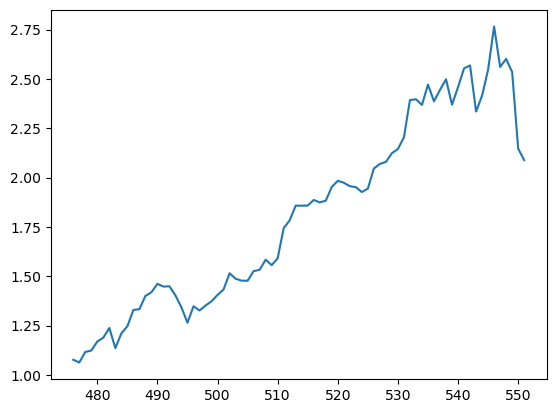

In [210]:
(1+assets.fact.Re1).cumprod().plot()